<a href="https://colab.research.google.com/github/shubhamkhan/Object-Detection/blob/master/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Inroduction**:


Aiming to minimize police response time by detecting objects in a live UAV camera.

### This notebook was designed to be ran from top to bottom with or without the need to mount Google Drive

## Object Detection Using Tensorflow Object Detection API

Project structure

```
detection/
        ├─ data/
        │    ├── images/
        │    │      ├── 1.jpg
        │    │      ├── 2.jpg
        │    │      └── ...
        |    | 
        │    ├── train_labels/
        │    │      ├── 0.xml
        │    │      ├── 1.xml
        │    │      └── ...
        |    |
        │    ├── test_labels/
        │    │      ├── 10.xml
        │    │      ├── 20.xml
        │    │      └── ...
        |    |
        │    ├── label_map.pbtxt
        │    ├── test_labels.csv
        │    ├── train_labels.csv
        │    ├── test_labels.record
        │    └── train_labels.record
        └─ models/
             ├─ research/
             │      ├── fine_tuned_model/
             │      │         ├── saved_model
             |      |         |      ├── saved_model.pb
             │      │         └── ...
             │      │         
             │      ├── pretrained_model/
             │      │         ├── saved_model
             |      |         |      ├── saved_model.pb
             |      |         ├── pipeline.config
             │      │         └── ...
             │      │         
             │      ├── object_detection/
             │      │         ├── utils/                               
             │      │         ├── exporter_main_v2.py
             │      │         ├── model_main_tf2.py
             │      │         └── ...
             │      │         
             │      ├── training/
             │      │         ├── events.out.tfevents.xxxxx
             │      │         └── ...               
             │      └── ...
             └── ...




## Choosing a pre training model
The model used for this project is `ssd_mobilenet_v2_keras`.
Check other models from [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

Because the interestes of this project is to interfere on real time video, i am chosing a model that has a high inference speed `(ms)` with relativly high `(mAP)` on COCO

In [ ]:
import os

# Number of training steps.
num_steps = 20000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

# set fine_tune_checkpoint_type.
checkpoint_type = 'detection'

test_record_file = '/content/detection/data/test_labels.record'
train_record_file = '/content/detection/data/train_labels.record'
label_map_pbtxt_file = '/content/detection/data/label_map.pbtxt'
fine_tune_checkpoint = '/content/detection/models/research/pretrained_model/checkpoint/ckpt-0'

# Some models to train on
MODELS_CONFIG = {
    # SSD MobileNet V2 FPNLite
    'ssd_mobilenet_v2_fpn_keras': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    },
    # SSD ResNet50 V1 FPN
    'ssd_resnet50_v1_fpn_keras': {
        'model_name': 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    },
     # SSD MobileNet V1 FPN
    'ssd_mobilenet_v1_fpn_keras': {
        'model_name': 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    },
    # Faster R-CNN ResNet50
    'faster_rcnn_resnet50_v1_keras': {
        'model_name': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    },
    # Faster R-CNN ResNet101 V1
    'faster_rcnn_resnet101_v1_keras': {
        'model_name': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    },
    # SSD ResNet101 V1 FPN 640x640
    'ssd_resnet101_v1_fpn_keras': {
        'model_name': 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 4
    },
    # Faster R-CNN Inception ResNet V2
    'faster_rcnn_inception_resnet_v2_keras': {
        'model_name': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8',
        'pipeline_file': 'pipeline.config',
        'batch_size': 8
    }
}
 
# Select a model in `MODELS_CONFIG`.
# I chose ssd_resnet50_v1_fpn_keras for this project, you could choose any
selected_model = 'ssd_mobilenet_v2_fpn_keras'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/detection/models/research/pretrained_model/"
 
#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']


#       Model name	                           Speed (ms)     COCO (mAP)
# --------------------------------------------------------------------
#[1] SSD MobileNet V2 FPNLite 640x640	            39           	28.2
#[2] SSD ResNet50 V1 FPN 640x640 (RetinaNet50)    46           	34.3
#[3] SSD MobileNet V1 FPN 640x640              	  48           	29.1
#[4] Faster R-CNN ResNet50 V1 640x640          	  53           	29.3
#[0] EfficientDet D1 640x640                   	  54           	38.4
#[5] Faster R-CNN ResNet101 V1 640x640         	  55           	31.8
#[6] SSD ResNet101 V1 FPN 640x640 (RetinaNet101)	57           	35.6
#[0] Faster R-CNN ResNet152 V1 640x640         	  64           	32.4
#[0] SSD ResNet152 V1 FPN 640x640 (RetinaNet152)	80           	35.4
#[7] Faster R-CNN Inception ResNet V2 640x640	    206           37.7

## Installing Required Packages 

In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
 
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools lvis tf-models-official tf_slim

Selecting previously unselected package python-bs4.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

### General imports
Other Imports will be done after downloading some packages later.

In [ ]:
from __future__ import division, print_function, absolute_import
 
import pandas as pd
import numpy as np
import csv
import re
import cv2 
import glob
import xml.etree.ElementTree as ET
 
import io
import tensorflow.compat.v2 as tf
 
from PIL import Image
from collections import namedtuple, OrderedDict
 
import shutil
import urllib.request
import tarfile
 
from google.colab import files

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
!nvidia-smi

Thu Jul 15 09:14:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and Orgniazing Images and Annotations
1. Downloading the images and annotations from the [source](https://drive.google.com/file/d/1WgoqZMFCPDa4vDeGEoCNqZiuMkdKpvXw/view)  and unziping them
2. Creating a directory `(data)` to save some data such as; images, annotation, csv, etc...
3. Creating two directories; for the training and testing labels (not the images)
4. Randomly splitting our labels into 80% training and 20% testing and moving the splits to their directories: `(train_labels)` & `(test_labels)` 

In [ ]:
#creates a directory for the whole project
!mkdir detection

In [ ]:
#Training images and annotations zip download

# #download the images zip
# !wget https://www.shubhamkhan.github.io/dataset.zip

#Download form public share google drive link (https://drive.google.com/file/d/1WgoqZMFCPDa4vDeGEoCNqZiuMkdKpvXw/view)
!gdown --id "1-h6zx66NZFDC0NMihEr_8LaTjSUdOZ0D"
# !gdown --id "1-J58Ox1MLEchY_84UXcgZcT9LjrzF5jU"
 
# #unzip the image file
# !unzip -q data.zip

Downloading...
From: https://drive.google.com/uc?id=1-h6zx66NZFDC0NMihEr_8LaTjSUdOZ0D
To: /content/people.zip
343MB [00:06, 55.1MB/s]


In [ ]:
!unzip -q people.zip

In [ ]:
cd /content/detection

/content/detection


In [ ]:
# creating a directory to store the training and testing data
!mkdir data
 
# folders for the training and testing data.
!mkdir data/images data/train_labels data/test_labels
 
# combining the images and annotation in the training folder:
# moves the images to data folder
!mv /content/data/images/* /content/detection/data/images
 
# moves the annotations to train_labels folder
!mv /content/data/annotations/* /content/detection/data/train_labels

In [ ]:
# Deleting the zipped and unzipped folders 
!rm -rf /content/data /content/data.zip

In [ ]:
# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 1300 labels to the testing dir: `test_labels`
!ls data/train_labels/* | sort -R | head -1300 | xargs -I{} mv {} data/test_labels

In [ ]:
# 5171 "images"(xml) for training
!ls -1 /content/detection/data/train_labels/ | wc -l

1200


In [ ]:
# 1300 "images"(xml) for testing
!ls -1 /content/detection/data/test_labels/ | wc -l

300


## Preprocessing Images and Labels (Take long time for checking) (No)
1. Converting the annotations from xml files to two csv files for each `train_labels/` and `train_labels/`.
2. Creating a pbtxt file that specifies the number of class (one class in this case)
3. Checking if the annotations for each object are placed within the range of the image width and height.

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
 
#converts the annotations/labels into one csv file for each training and testing labels
#creats label_map.pbtxt file
 
%cd /content/detection/data
 
# images extension
# images_extension = 'jpg'
 
# takes the path of a directory that contains xml files and converts
#  them to one csv file.
 
# returns a csv file that contains: image name, width, height, class, xmin, ymin, xmax, ymax.
# note: if the xml file contains more than one box/label, it will create more than one row for the same image. each row contains the info for an individual box. 
def xml_to_csv(path):
  classes_names = []
  xml_list = []
 
  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text, #+ '.' + images_extension,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names
 
# for both the train_labels and test_labels csv files, it runs the xml_to_csv() above.
for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')
 
# Creating the `label_map.pbtxt` file
label_map_path = os.path.join("label_map.pbtxt")
 
pbtxt_content = ""
 
#creats a pbtxt file the has the class names.
for i, class_name in enumerate(classes):
    # display_name is optional.
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: '{1}'\n }}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

/content/detection/data
Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [ ]:
#checking the pbtxt file
# !cat label_map.pbtxt

 
item {
    id: 1
    name: 'people'
    display_name: 'People'
 }

In [ ]:
#If you want to change display_name

%%writefile /content/detection/data/label_map.pbtxt
 
item {
    id: 1
    name: 'awning-tricycle'
    display_name: 'awning-tricycle'
 }
 
item {
    id: 2
    name: 'bicycle'
    display_name: 'bicycle'
 }
 
item {
    id: 3
    name: 'bus'
    display_name: 'bus'
 }
 
item {
    id: 4
    name: 'car'
    display_name: 'car'
 }
 
item {
    id: 5
    name: 'ignored regions'
    display_name: 'ignored regions'
 }
 
item {
    id: 6
    name: 'motor'
    display_name: 'motor'
 }
 
item {
    id: 7
    name: 'others'
    display_name: 'others'
 }
 
item {
    id: 8
    name: 'pedestrian'
    display_name: 'pedestrian'
 }
 
item {
    id: 9
    name: 'people'
    display_name: 'people'
 }
 
item {
    id: 10
    name: 'tricycle'
    display_name: 'tricycle'
 }
 
item {
    id: 11
    name: 'truck'
    display_name: 'truck'
 }
 
item {
    id: 12
    name: 'van'
    display_name: 'van'
 }

In [ ]:
# they are there!
!ls -l

total 2304
drwxr-xr-x 2 root root  339968 Jun 17 15:49 images
-rw-r--r-- 1 root root      67 Jun 17 17:08 label_map.pbtxt
drwxr-xr-x 2 root root   69632 Jun 17 15:49 test_labels
-rw-r--r-- 1 root root  318658 Jun 17 17:09 test_labels.csv
drwxr-xr-x 2 root root  335872 Jun 17 15:49 train_labels
-rw-r--r-- 1 root root 1285434 Jun 17 17:10 train_labels.csv


In [ ]:
# checks if the images box position is placed within the image.
 
# note: while this doesn't checks if the boxes/annotatoins are correctly
# placed around the object, Tensorflow will through an error if this occured.
%cd /content/detection/data
# path to images
images_path = 'images'
 
# loops over both train_labels and test_labels csv files to do the check
# returns the image name where an error is found 
# return the incorrect attributes; xmin, ymin, xmax, ymax.
for CSV_FILE in ['train_labels.csv', 'test_labels.csv']:
  with open(CSV_FILE, 'r') as fid:  
      print('[*] Checking file:', CSV_FILE) 
      file = csv.reader(fid, delimiter=',')
      first = True 
      cnt = 0
      error_cnt = 0
      error = False
      for row in file:
          if error == True:
              error_cnt += 1
              error = False         
          if first == True:
              first = False
              continue     
          cnt += 1      
          name, width, height, xmin, ymin, xmax, ymax = row[0], int(row[1]), int(row[2]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
          path = os.path.join(images_path, name)
          img = cv2.imread(path)         
          if type(img) == type(None):
              error = True
              print('Could not read image', img)
              continue     
          org_height, org_width = img.shape[:2]     
          if org_width != width:
              error = True
              print('Width mismatch for image: ', name, width, '!=', org_width)     
          if org_height != height:
              error = True
              print('Height mismatch for image: ', name, height, '!=', org_height) 
          if xmin > org_width:
              error = True
              print('XMIN > org_width for file', name)  
          if xmax > org_width:
              error = True
              print('XMAX > org_width for file', name)
          if ymin > org_height:
              error = True
              print('YMIN > org_height for file', name)
          if ymax > org_height:
              error = True
              print('YMAX > org_height for file', name)
          if error == True:
              print('Error for file: %s' % name)
              print()
      print()
      print('Checked %d files and realized %d errors' % (cnt, error_cnt))
      print("-----")

/content/detection/data
[*] Checking file: train_labels.csv

Checked 282428 files and realized 0 errors
-----
[*] Checking file: test_labels.csv

Checked 71122 files and realized 0 errors
-----


In [ ]:
# #we have only one image with incorrect box position, we could just remove it 
# #removing the image 
# !rm images/'12345.jpg'

# #removing the entry for it in the csv for that image as well
 
# #because we did a random split for the data, we dont know if it ended up being in training or testing
# # we will remove the image from both.
 
# #training
# #reading the training csv
# df = pd.read_csv('/content/detection/data/train_labels.csv')
# # removing 12345.jpg
# df = df[df['filename'] != '12345.jpg']
# #reseting the index
# df.reset_index(drop=True, inplace=True)
# #saving the df
# df.to_csv('/content/detection/data/train_labels.csv')
 
 
# #testing
# #reading the testing csv
# df = pd.read_csv('/content/detection/data/test_labels.csv')
# # removing 12345.jpg
# df = df[df['filename'] != '12345.jpg']
# #reseting the index
# df.reset_index(drop=True, inplace=True)
# #saving the df
# df.to_csv('/content/detection/data/test_labels.csv')
 
# # Just for the memory
# df = None

## Downloading and Preparing Tensorflow model
1. Cloning [Tensorflow models](https://github.com/tensorflow/models.git) from the offical git repo. The repo contains the object detection API we are interseted in. 
2. Compiling the protos and adding folders to the os environment.
3. Testing the model builder.

In [ ]:
# Downlaods Tenorflow
%cd /content/detection/
!git clone --q https://github.com/tensorflow/models.git

/content/detection


In [ ]:
%cd /content/detection/models/research
# compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.
 
# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/detection/models/research/:/content/detection/models/research/slim/'

/content/detection/models/research


In [ ]:
# testing the model builder
!python3 object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0715 09:16:14.102273 139704420718464 model_builder.py:1088] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 6.49s
I0715 09:16:14.340337 139704420718464 test_util.py:2103] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 6.49s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.55s
I0715 09:16:14.886291 139704420718464 test_util.py:2103] time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.55s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
[ RUN     

## Generating Tf record
- Generating two TFRecords files for the training and testing CSVs.
- Tensorflow accepts the data as tfrecords which is a binary file that run fast with low memory usage. Instead of loading the full data into memory, Tenorflow breaks the data into batches using these TFRecords automatically

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
 
# converts the csv files for training and testing data to two TFRecords files.
# places the output in the same directory as the input
 
from object_detection.utils import dataset_util
%cd /content/detection/models
 
DATA_BASE_PATH = '/content/detection/data/'
image_dir = DATA_BASE_PATH +'images/'
 
def class_text_to_int(row_label):
        if row_label == 'people':
                return 1
        else:
                None
        # if row_label == 'awning-tricycle':
        #         return 1
        # elif row_label == 'bicycle':
        #         return 2
        # elif row_label == 'bus':
        #         return 3
        # elif row_label == 'car':
        #         return 4
        # elif row_label == 'ignored regions':
        #         return 5
        # elif row_label == 'motor':
        #         return 6
        # elif row_label == 'others':
        #         return 7
        # elif row_label == 'pedestrian':
        #         return 8
        # elif row_label == 'people':
        #         return 9
        # elif row_label == 'tricycle':
        #         return 10
        # elif row_label == 'truck':
        #         return 11
        # elif row_label == 'van':
        #         return 12
        # else:
        #         None
 
def split(df, group):
        data = namedtuple('data', ['filename', 'object'])
        gb = df.groupby(group)
        return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]
 
def create_tf_example(group, path):
        with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
                encoded_jpg = fid.read()
        encoded_jpg_io = io.BytesIO(encoded_jpg)
        image = Image.open(encoded_jpg_io)
        width, height = image.size
 
        filename = group.filename.encode('utf8')
        image_format = b'jpg'
        xmins = []
        xmaxs = []
        ymins = []
        ymaxs = []
        classes_text = []
        classes = []
 
        for index, row in group.object.iterrows():
                xmins.append(row['xmin'] / width)
                xmaxs.append(row['xmax'] / width)
                ymins.append(row['ymin'] / height)
                ymaxs.append(row['ymax'] / height)
                classes_text.append(row['class'].encode('utf8'))
                classes.append(class_text_to_int(row['class']))
 
        tf_example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': dataset_util.int64_feature(height),
                'image/width': dataset_util.int64_feature(width),
                'image/filename': dataset_util.bytes_feature(filename),
                'image/source_id': dataset_util.bytes_feature(filename),
                'image/encoded': dataset_util.bytes_feature(encoded_jpg),
                'image/format': dataset_util.bytes_feature(image_format),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes),
        }))
        return tf_example
 
for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))

/content/detection/models
Successfully created the TFRecords: /content/detection/data/train_labels.record
Successfully created the TFRecords: /content/detection/data/test_labels.record


In [ ]:
# TFRecords are created
!ls -lX /content/detection/data/

total 168396
drwx------ 2 root root     73728 Jun 18 17:27 images
drwx------ 2 root root     20480 Jun 18 17:57 test_labels
drwx------ 2 root root     69632 Jun 18 17:57 train_labels
-rw------- 1 root root    239115 Jun 18 18:19 test_labels.csv
-rw------- 1 root root    993588 Jun 18 18:20 train_labels.csv
-rw------- 1 root root        67 Jun 18 18:04 label_map.pbtxt
-rw------- 1 root root  34025482 Jun 18 18:34 test_labels.record
-rw------- 1 root root 136998258 Jun 18 18:34 train_labels.record


## Downloading the Base Model
1. Based on the model selecting at the top of this notebook, downloading the model selected and extracting its content.
2. Creating a dir to save the model while training.

In [ ]:
!rm -rf /content/detection/models/research/pretrained_model

In [ ]:
%cd /content/detection/models/research
 
# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']
 
# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
 
#selecting the model
MODEL_FILE = MODEL + '.tar.gz'
 
#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
 
#the distination folder where the model will be saved
fine_tune_dir = '/content/detection/models/research/pretrained_model'
 
#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
 
#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()
 
# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/detection/models/research


In [ ]:
#checking the content of the pretrained model.
# this is the directory of the "fine_tune_checkpoint" that is used in the config file.
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/detection/models/research/pretrained_model
total 24K
drwxr-x---  4 345018 89939 4.0K Jul 11  2020 .
drwxr-xr-x 23 root   root  4.0K Jul 14 10:31 ..
drwxr-x---  2 345018 89939 4.0K Jul 10  2020 checkpoint
-rw-r-----  1 345018 89939 4.5K Jul 11  2020 pipeline.config
drwxr-x---  3 345018 89939 4.0K Jul 10  2020 saved_model


## Configuring the Training Pipeline
1. Adding the path for the TFRecords files and pbtxt,batch_size,num_steps,num_classes to the configuration file.
2. Adding some Image augmentation.
3. Creating a directory to save the model at each checkpoint while training. 

In [ ]:
print(model_pipline)

/content/detection/models/research/pretrained_model/pipeline.config


In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_file)

#open the file
with open(model_pipline) as f:
    s = f.read()

with open(model_pipline, "w") as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
            'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # tfrecord files train and test.
    s = re.sub('input_path: ".*?"',
            'input_path: "{}"'.format(test_record_file), s, 0)

    s = re.sub('input_path: ".*?"',
            'input_path: "{}"'.format(train_record_file), s, 1)

    # label_map_path
    s = re.sub('label_map_path: ".*?"',
            'label_map_path: "{}"'.format(label_map_pbtxt_file), s)

    # fine_tune_checkpoint_type
    s = re.sub('fine_tune_checkpoint_type: ".*?"',
            'fine_tune_checkpoint_type: "{}"'.format(checkpoint_type), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
# !cat {model_pipline}

# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint

# Achieves -- mAP on COCO14 minival dataset.

# This config is TPU compatible.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 640
        max_dimension: 640
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    f

In [ ]:
# If you want to manually configuration
#editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

#path to the config file
# %%writefile /content/detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
%%writefile {model_pipline}

model {
  ssd {
    num_classes: 12 # number of classes to be detected
    # all images will be resized to the below W x H.
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            # weight: 3.9999998989515007e-05
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              # weight: 3.9999998989515007e-05
              weight: 0.001 # higher regularizition to counter overfitting
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019165
            scale: true
            epsilon: 0.0010000000474974513
          }
        }
        depth: 128
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
        share_prediction_tower: true
        use_depthwise: true
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.6000000238418579
        use_static_shapes: false
        # adjust this to the max number of objects per class. 
        # ex, in my case, i have one pistol in most of the images.
        # there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 60
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 12 # training batch size
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.07999999821186066
          total_steps: 50000
          warmup_learning_rate: 0.026666000485420227
          warmup_steps: 1000
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  # The path to the pretrained model. 
  fine_tune_checkpoint: "/content/detection/models/research/pretrained_model/checkpoint/ckpt-0"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 1000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection" # Select checkpoint type
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  #path to the label map
  label_map_path: "/content/detection/data/label_map.pbtxt"
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/content/detection/data/train_labels.record"
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  # the number of images in your "testing" data (was 1300 and we not removed above :) )
  num_examples: 1300
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20
 
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
}
eval_input_reader {
  #path to the label map
  label_map_path: "/content/detection/data/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    #path to the testing TFRecord
    input_path: "/content/detection/data/test_labels.record"
  }
}

#data augmentaion is done here, you can remove or add more.
# They will help the model generalize but the training time will increase greatly by using more data augmentation.
# Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto

Overwriting /content/detection/models/research/pretrained_model/pipeline.config


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# where the model will be saved at each checkpoint while training 
# model_dir = 'training/'
model_dir = '/content/drive/MyDrive/uav/people/training'
 
# Optionally: remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

### Tensorboard
1. Downlaoding and unzipping Tensorboard
2. creating a link to visualize multiple graph while training.


notes: 
  1. Tensorboard will not log any files until the training starts. 
  2. a max of 20 connection per minute is allowed when using ngrok, you will not be able to access tensorboard while the model is logging.

In [ ]:
#downlaoding ngrok to be able to access tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-06-30 04:48:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.217.9.201, 35.175.10.123, 52.55.225.227, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.217.9.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  16.1MB/s    in 0.8s    

2021-06-30 04:48:15 (16.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
#the logs that are created while training 
LOG_DIR =model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
#The link to tensorboard.
#works after the training starts.
 
### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://bc1fc74f4572.ngrok.io


In [ ]:
# Run tensorboard server
# !tensorboard --logdir=/content/drive/MyDrive/uav/training/train

2021-06-22 04:25:08.312042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.5.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Training

Finally training the model!


In [ ]:
%cd /content/detection/models/research

/content/detection/models/research


In [ ]:
!python3 /content/detection/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={model_pipline} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

2021-06-22 04:25:34.929143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-22 04:25:37.350404: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-22 04:25:37.372454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-22 04:25:37.373267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-06-22 04:25:37.373320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-22 04:25:37.394313: I tensorflow/stream_executor/platform/defa

In [ ]:
!python3 /content/detection/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={model_pipline} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps} \
    --checkpoint_dir={model_dir} \

W0619 10:37:27.274712 140175242626944 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0619 10:37:27.274968 140175242626944 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0619 10:37:27.275073 140175242626944 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0619 10:37:27.275179 140175242626944 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0619 10:37:27.275269 140175242626944 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0619 10:37:27.275413 140175242626944 model_lib_v2.py:1103] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:Reading unweighted datasets: ['/content

In [ ]:
!python3 /content/detection/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={model_pipline} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps} \
    --checkpoint_dir={model_dir} \

2021-06-30 05:34:34.288197: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
W0630 05:34:36.176119 139625737414528 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0630 05:34:36.176327 139625737414528 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0630 05:34:36.176415 139625737414528 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0630 05:34:36.176498 139625737414528 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0630 05:34:36.176593 139625737414528 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0630 05:34:36.176707 139625737414528 model_lib_v2.py:1103] Expected number of evaluation epochs is 1, but inste

## Exporting The Trained model



In [ ]:
#the location where the exported model will be saved in.
output_directory = '/content/detection/models/research/fine_tuned_model'
 
#goes through the model is the training/ dir and gets the last one 
#exports the model specifed and inference graph
!python3 /content/detection/models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_dir={model_dir} \

2021-06-30 05:48:35.973062: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-30 05:48:37.627067: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-30 05:48:37.658270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-30 05:48:37.658872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-30 05:48:37.658917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-30 05:48:37.661590: I tensorflow/stream_executor/platform/default

In [ ]:
#downloads the frozen model that is needed for inference
files.download(output_directory + '/saved_model/saved_model.pb')

#downlaod the label map
files.download(DATA_BASE_PATH + '/label_map.pbtxt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run inference graph model test
Test a images with `models/research/fine_tuned_model` directory.

Loading model...Done! Took 12.488127708435059 seconds
Running inference for /content/drive/MyDrive/uav/people/1.jpg... Done


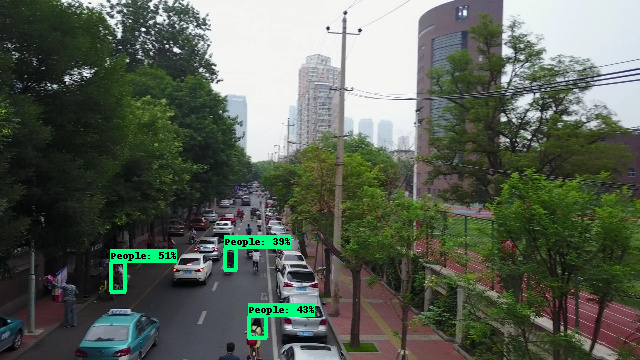

In [ ]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/drive/MyDrive/uav/people/1.jpg'

# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/uav/people/fine_tuned_model'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/MyDrive/uav/people/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.3,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)

## Move data to Google Drive

In [ ]:
!mkdir /content/drive/MyDrive/dataset

!mkdir /content/drive/MyDrive/dataset/training
!mv /content/detection/models/research/training/* /content/drive/MyDrive/dataset/training/

!mkdir /content/drive/MyDrive/dataset/fine_tuned_model
!mv /content/detection/models/research/fine_tuned_model* /content/drive/MyDrive/dataset/fine_tuned_model/

!mv /content/detection/data/label_map.pbtxt /content/drive/MyDrive/dataset/

!mv /content/detection/models/research/pretrained_model/pipeline.config /content/drive/MyDrive/dataset/

In [ ]:
!mv /content/detection/models/research/fine_tuned_model/* /content/drive/MyDrive/uav/fine_tuned_model/

## Data processing help

In [ ]:
!gdown --id "1WgoqZMFCPDa4vDeGEoCNqZiuMkdKpvXw"
!unzip -q Annotations_XML.zip

!gdown --id "1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn"
!unzip -q VisDrone2019-DET-train.zip

!rm -rf VisDrone2019-DET-train.zip Annotations_XML.zip

!mkdir dataset
!mv /content/VisDrone2019-DET-train/* /content/dataset/
!rm -rf /content/VisDrone2019-DET-train /content/dataset/annotations/*

!mv /content/Annotations/* /content/dataset/images/
!rm -rf /content/Annotations

!git clone https://github.com/italojs/resize_dataset_pascalvoc.git
!python3 /content/resize_dataset_pascalvoc/main.py -p /content/dataset/images --output /content/dataset --new_x 640 --new_y 360 --save_box_images 1

Downloading...
From: https://drive.google.com/uc?id=1WgoqZMFCPDa4vDeGEoCNqZiuMkdKpvXw
To: /content/Annotations_XML.zip
8.82MB [00:00, 77.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn
To: /content/VisDrone2019-DET-train.zip
1.55GB [00:10, 144MB/s]


In [ ]:
cd /content/drive/MyDrive/uav
!zip -r ./data.zip ./data

Streaming output truncated to the last 5000 lines.
  adding: data/annotations/9999970_00000_d_0000046.xml (deflated 92%)
  adding: data/annotations/0000351_01961_d_0000529.xml (deflated 92%)
  adding: data/annotations/9999999_00081_d_0000027.xml (deflated 92%)
  adding: data/annotations/9999994_00000_d_0000084.xml (deflated 92%)
  adding: data/annotations/9999967_00000_d_0000055.xml (deflated 92%)
  adding: data/annotations/9999977_00000_d_0000072.xml (deflated 78%)
  adding: data/annotations/9999982_00000_d_0000048.xml (deflated 88%)
  adding: data/annotations/9999953_00000_d_0000151.xml (deflated 84%)
  adding: data/annotations/9999937_00000_d_0000164.xml (deflated 88%)
  adding: data/annotations/0000290_02801_d_0000861.xml (deflated 93%)
  adding: data/annotations/9999999_00430_d_0000190.xml (deflated 91%)
  adding: data/annotations/0000305_00601_d_0000216.xml (deflated 90%)
  adding: data/annotations/0000334_00981_d_0000026.xml (deflated 92%)
  adding: data/annotations/0000068_0317